## Background

Edge detection is a fundamental technique in image processing used to segment images by identifying regions with abrupt (local) changes in intensity. Edge pixels are those where the intensity of an image changes sharply, and edges (or edge segments) are continuous sets of such edge pixels. Detecting these abrupt changes is crucial for understanding the structure and features within an image.

### Derivatives in Edge Detection

Abrupt, local changes in intensity can be detected using derivatives. In the context of digital images, derivatives are approximated using finite differences. Specifically, we can approximate the first-order derivative of a one-dimensional function $f(x)$ at an arbitrary point $x$ by expanding $f(x + \Delta x)$ into a Taylor series about $x$:

$$
f(x + \Delta x) = f(x) + \frac{\partial f}{\partial x} \Delta x + \frac{1}{2} \frac{\partial^2 f}{\partial x^2} (\Delta x)^2 + \frac{1}{6} \frac{\partial^3 f}{\partial x^3} (\Delta x)^3 + \cdots
$$

Here, $\Delta x$ is the separation between samples of $f$, and is assumed to be either +1 or -1.

### Finite Difference Approximations

To compute intensity differences, we often use only a few terms of the Taylor series. For first-order derivatives, we use only the linear terms and can form differences in three ways:

1. **Forward Difference** :
   
   $$
   \frac{\partial f}{\partial x} \approx f(x + 1) - f(x)
   $$
   
2. **Backward Difference**:
   
   $$
   \frac{\partial f}{\partial x} \approx f(x) - f(x - 1)
   $$
   
3. **Central Difference**:
   
   By subtracting the backward difference from the forward difference, we obtain:
   
   $$
   \frac{\partial f}{\partial x} \approx \frac{f(x + 1) - f(x - 1)}{2}
   $$

For the second-order derivative based on a central difference, we have:

$$
\frac{\partial^2 f}{\partial x^2} \approx f(x + 1) - 2f(x) + f(x - 1)
$$

### Extending to Two Variables

For functions of two variables, we apply the finite difference results to each variable independently.

$$
\frac{\partial f}{\partial x} = \frac{f(x + 1, y) - f(x - 1, y)}{2}
$$

$$
\frac{\partial f}{\partial y} = \frac{f(x, y + 1) - f(x, y - 1)}{2}
$$

Similarly, the second-order partial derivatives are obtained by applying the finite difference approximations to each variable:

$$
\frac{\partial^2 f}{\partial x^2} = f(x + 1, y) - 2f(x, y) + f(x - 1, y)
$$

$$
\frac{\partial^2 f}{\partial y^2} = f(x, y + 1) - 2f(x, y) + f(x, y - 1)
$$

### Implications of First and Second-Order Derivatives

- **First-Order Derivatives**: These generally produce "thicker" edges. The magnitude of the response at a point is relatively weaker compared to second-order derivatives. This is because first-order derivatives are less aggressive in enhancing sharp changes, making them suitable for detecting broader transitions in intensity.
  
- **Second-Order Derivatives**: These produce much thinner edges with a stronger response to fine details such as thin lines, isolated points, and noise. Second-order derivatives are more aggressive in enhancing sharp changes, which helps in highlighting fine details but also makes them more sensitive to noise. The sign of the second derivative can be used to determine the direction of the intensity transition—whether it is from light to dark or dark to light.

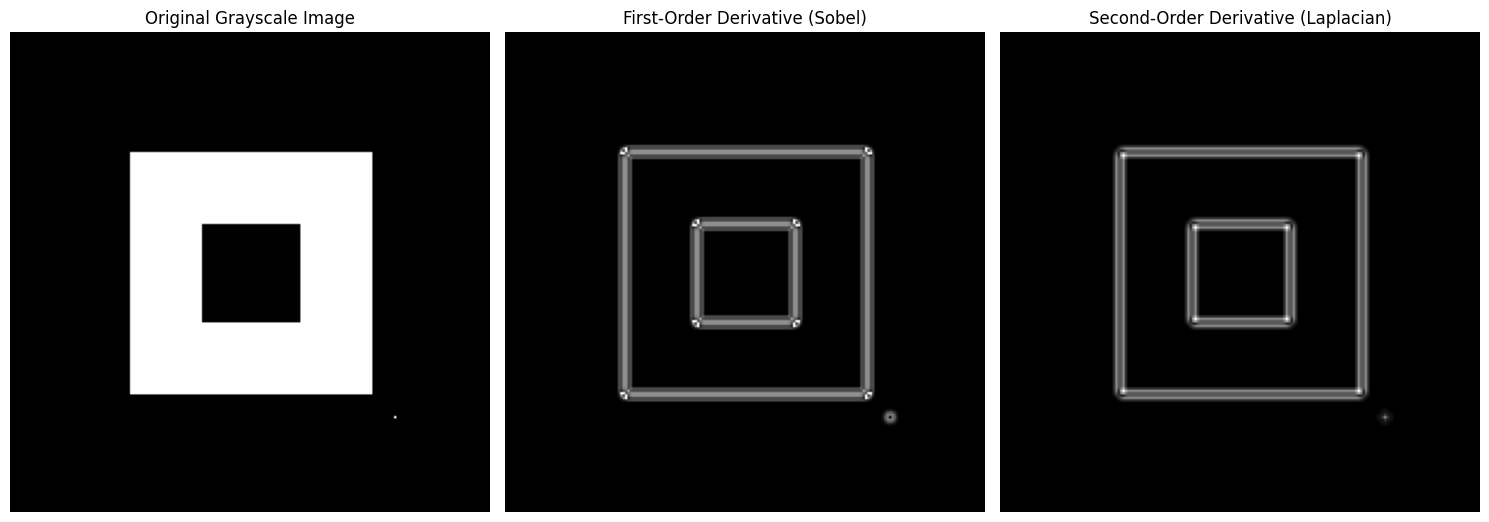

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Creating an image manually for demnonstration
image = np.zeros((200, 200), dtype=np.uint8)
cv2.rectangle(image, (50, 50), (150, 150), 255, -1)  # Filled rectangle
cv2.rectangle(image, (80, 80), (120, 120), 0, -1)  # Filled smaller square\
image[160, 160] = 255

# Apply Gaussian Blur, a recommended pre-processing step in edge detection
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# First-Order Derivative using Sobel Operator
sobel_x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
sobel_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
sobel_magnitude = np.uint8(np.absolute(sobel_magnitude))

# Second-Order Derivative using Laplacian Operator
laplacian = cv2.Laplacian(blurred, cv2.CV_64F)
laplacian = np.uint8(np.absolute(laplacian))

# Plotting the results
plt.figure(figsize=(15, 10))

# Original Image
plt.subplot(1,3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')

# First-Order Derivative (Sobel)
plt.subplot(1,3, 2)
plt.imshow(sobel_magnitude, cmap='gray')
plt.title('First-Order Derivative (Sobel)')
plt.axis('off')

# Second-Order Derivative (Laplacian)
plt.subplot(1,3, 3)
plt.imshow(laplacian, cmap='gray')
plt.title('Second-Order Derivative (Laplacian)')
plt.axis('off')

plt.tight_layout()
plt.show()


## Fundamentals of Edge Detection

Edge detection typically involves three fundamental steps:

1. **Image Smoothing for Noise Reduction**: Before detecting edges, it is essential to reduce noise in the image, as noise can lead to false edge detections and obscure true edges. Edge detection algorithms are highly sensitive to noise. Even slight variations in pixel intensity can be misinterpreted as edges. Noise reduction is achieved through image smoothing, which involves applying a low-pass filter to the image to blur it slightly and eliminate high-frequency noise components.
2. **Detection of Edge Points**: After noise reduction, the next step is to detect potential edge points within the smoothed image. This involves identifying pixels where there is a significant change in intensity, indicating a possible edge.
3. **Edge Localization**: The final step involves refining the detected edge points to produce a well-defined and precise edge map. This step ensures that only the most accurate edge points are retained, eliminating false positives and ensuring edge continuity.

## Basic Edge Detection

The fundamental tool for determining edge strength and direction at any arbitrary location $(x, y)$ in an image $f$ is the **gradient**, denoted by $\nabla f$. This vector possesses the well-known property of pointing in the direction of the **maximum rate of change** of $f$ at the point $(x, y)$. Mathematically, this is expressed as:

$$
\nabla f(x, y) = \begin{bmatrix}
\frac{\partial f}{\partial x}(x, y) \\
\frac{\partial f}{\partial y}(x, y)
\end{bmatrix}
$$

### Gradient Magnitude and Direction

The **magnitude** of the gradient vector at a point $(x, y)$, denoted by $M(x, y)$, quantifies the rate of intensity change in the direction of the gradient. It is calculated using the Euclidean norm:

$$
M(x, y) = |\nabla f(x, y)| = \sqrt{\left(\frac{\partial f}{\partial x}(x, y)\right)^2 + \left(\frac{\partial f}{\partial y}(x, y)\right)^2} \quad 
$$

This implementation is not always desirable because of the computational burden required by squares and square roots, and an approach used frequently is to approximate the magnitude of the gradient by absolute values: 
$$
M(x, y) = |\frac{\partial f}{\partial x}(x, y)| + |\frac{\partial f}{\partial y}(x, y)|
$$

The **direction** of the gradient vector, denoted by $\theta(x, y)$, indicates the angle of the maximum intensity change relative to the x-axis. It is computed as:

$$
\theta(x, y) = \tan^{-1}\left(\frac{\frac{\partial f}{\partial y}(x, y)}{\frac{\partial f}{\partial x}(x, y)}\right) \quad 
$$



### Gradient Image

When the gradient is evaluated across all applicable pixel locations $(x, y)$ in the image $f$, it produces a **gradient image**. Each element in this image is a vector $\nabla f(x, y)$, and both the magnitude $M(x, y)$ and the direction $\theta(x, y)$ are arrays of the same size as the original image $f$. These arrays are created through element-wise operations.

### Edge Direction and Gradient Relationship

An important property of the gradient in edge detection is that the **direction of an edge** at any point $(x, y)$ is **orthogonal** to the gradient vector at that point. This means that if the gradient vector points in a particular direction, the edge itself runs perpendicular to that direction.

## Gradient Operators

Obtaining the gradient of an image requires computing the partial derivatives $g_x$ and $g_y$ at every pixel location in the image. To effectively compute these partial derivatives across an entire image, we employ convolution kernels (also known as gradient operators). These kernels are matrices that, when convolved with the image, approximate the derivatives in the $x$ and $y$ directions. The most common gradient operators are the **Prewitt**, and the **Sobel**. The Prewitt kernels are simpler to implement than the Sobel kernels, but the slight computational difference between them typically is not an issue. The fact that the Sobel kernels have better noise-suppression (smoothing) characteristics makes them preferable

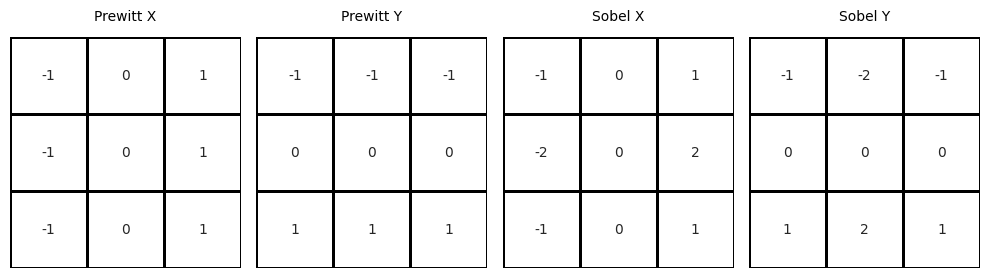

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


prewitt_x = np.array([[-1, 0, 1],
                      [-1, 0, 1],
                      [-1, 0, 1]])
prewitt_y = np.array([[-1, -1, -1],
                      [ 0,  0,  0],
                      [ 1,  1,  1]])

sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1],
                    [ 0,  0,  0],
                    [ 1,  2,  1]])

# Create a dictionary for all kernels for easier plotting
kernels = {
    "Prewitt X": prewitt_x,
    "Prewitt Y": prewitt_y,
    "Sobel X": sobel_x,
    "Sobel Y": sobel_y
}

# Function to plot matrices using seaborn heatmap
def plot_matrix(kernel_name, matrix, ax):
    sns.heatmap(matrix, annot=True, cmap='gray_r', cbar=False, fmt="d", vmin=0, vmax=0,
                linewidths=1, linecolor='black', square=True, ax=ax)
    ax.set_title(kernel_name, pad=12, fontsize=10)
    ax.axis('off')

# Set up a figure with subplots for each kernel
fig, axes = plt.subplots(1, 4, figsize=(10, 10))
axes = axes.flatten()

# Plot each kernel
for ax, (kernel_name, matrix) in zip(axes, kernels.items()):
    plot_matrix(kernel_name, matrix, ax)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# Canny Edge Detection

Canny edge detection is a multi-step process that aims to detect a wide range of edges in images. Its effectiveness relies on achieving three fundamental objectives:

1. **Low Error Rate**: The algorithm should effectively detect all true edges while avoiding false positives 
2. **Edge Localization**: Detected edges should be precisely localized, meaning that the identified edge points should be as close as possible to the actual edges in the image.
3. **Single Edge Point Response**: For each true edge point, the detector should produce only one corresponding point in the output.

We implement the Canny edge detection algorithm step by step and finally compare its performance with the OpenCV implementation.

In [8]:
# Add some noise to the image
def add_impulse_noise(image, noise_prob):
    Noise = np.random.random(image.shape)
    noisy_image = image.copy()
    
    salt_ind = Noise < noise_prob
    pepper_ind = Noise > 1 - noise_prob
    
    noisy_image[salt_ind] = 255
    noisy_image[pepper_ind] = 0
    
    return noisy_image

In [9]:
# Step 1: Apply Gaussian Blur
from scipy.signal import convolve2d 

def distance(x1, y1, x2, y2):
    return (x1 - x2) ** 2 + (y1 - y2) ** 2

def apply_gaussain_filter(image, kernel_size, sigma):
    blurred_image = image.copy()
    kernel = np.zeros((kernel_size, kernel_size))
    center = kernel_size // 2
    
    for i in range(kernel_size):
        for j in range(kernel_size):
            kernel[i, j] = np.exp(-1 * distance(i, j, center, center) / (2 * sigma ** 2))
            
    kernel /= np.sum(kernel)
    for i in range(3):
        blurred_image[:, :, i] = convolve2d(image[:, :, i], kernel, mode='same', boundary='fill', fillvalue=0)
    
    blurred_image = blurred_image.astype(np.uint8)
    return blurred_image

As discussed above, we use L1 norm to approximate the gradient magnitude. This is based on the inspiration from the OpenCV implementation of the Canny edge detection algorithm. 

In [10]:
# Step 2: Find the gradient magnitude and direction : We particularly use Sobel operator due to its effectiveness in noise suppression.
def gradient (gray_image):
    kernelx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernely = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    
    grad_x = convolve2d(gray_image, kernelx, mode='same', boundary='fill', fillvalue=0)
    grad_y = convolve2d(gray_image, kernely, mode='same', boundary='fill', fillvalue=0)
    
    grad_mag = abs(grad_x) + abs(grad_y) #np.sqrt(grad_x ** 2 + grad_y ** 2)
    grad_dir = np.arctan2(grad_y, grad_x) * 180 / np.pi
    
    return grad_mag, grad_dir


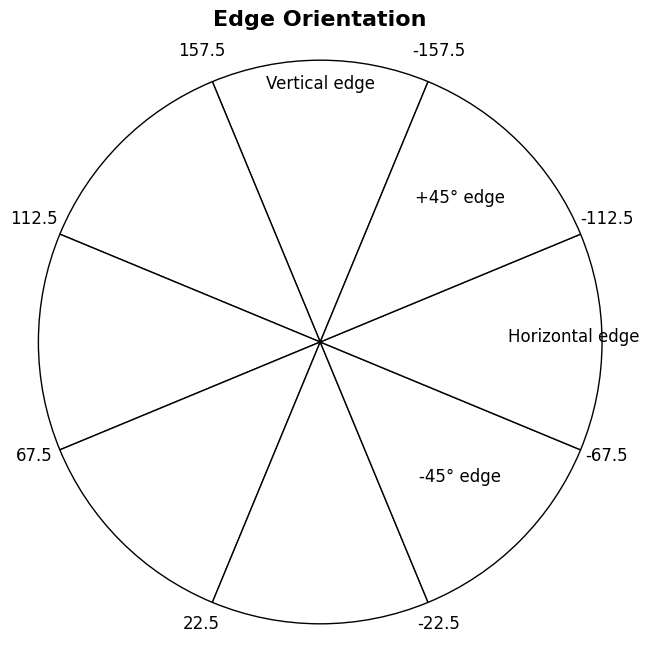

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Define the angles and labels
angles = [-157.5, -112.5, -67.5, -22.5, 22.5, 67.5, 112.5, 157.5]
labels = ['-157.5°', '-112.5°', '-67.5°', '-22.5°', '22.5°', '67.5°', '112.5°', '157.5°']

# Define colors for each wedge
colors = ['w'] * len(angles)

# Create a pie chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))

# Adding wedge properties and starting angle
wedges, texts = ax.pie([1] * len(angles),colors=colors, startangle=67.5,
                       wedgeprops=dict(linewidth=1, edgecolor='black'))

# Calculate the angle for annotation placement
angle_positions = np.array(angles) * np.pi / 180  # Convert to radians

# Define edge annotations and their corresponding angles
edge_labels = {
    'Vertical edge': (0, 0.9),
    '+45° edge': (0.7 * np.cos(np.radians(45)), 0.7 * np.sin(np.radians(45))),
    '-45° edge': (0.7 * np.cos(np.radians(-45)), 0.7 * np.sin(np.radians(-45))),
    'Horizontal edge': (0.9, 0),
    '157.5': (1.1 * np.cos(np.radians(112.5)), 1.1 * np.sin(np.radians(112.5))),
    '-157.5': (1.1 * np.cos(np.radians(67.5)), 1.1 * np.sin(np.radians(67.5))),
    '-112.5': (1.1 * np.cos(np.radians(22.5)), 1.1 * np.sin(np.radians(22.5))),
    '112.5': (1.1 * np.cos(np.radians(157.5)), 1.1 * np.sin(np.radians(157.5))),
    '67.5': (1.1 * np.cos(np.radians(-157.5)), 1.1 * np.sin(np.radians(-157.5))),
    '-67.5': (1.1 * np.cos(np.radians(-22.5)), 1.1 * np.sin(np.radians(-22.5))),
    '22.5': (1.1 * np.cos(np.radians(-112.5)), 1.1 * np.sin(np.radians(-112.5))),
    '-22.5': (1.1 * np.cos(np.radians(-67.5)), 1.1 * np.sin(np.radians(-67.5))
    )
}

# Adding annotations at corresponding positions
for label, (x, y) in edge_labels.items():
    ax.annotate(label, xy=(x, y), fontsize=12, ha='center', color='black')

# Title and show
plt.title("Edge Orientation", fontsize=16, fontweight='bold')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()



Gradient images typically have thick edges. We thin them using non-maximum suppression. It involves the following steps:
1. The gradient direction is quantized into discrete directions as shown in the diagram above. 
    67.5° to 112.5° and -112.5° to -67.5°: Horizontal
    -22.5° to 22.5° and -157.5° to 157.5°: Vertical
    22.5° to 67.5° and -157.5° to -112.5°: +45°
    -67.5° to -22.5° and 112.5° to 157.5°: -45°
2. For each pixel, we find the direction closest to the pixel's gradient direction. 
3. We compare the pixel's gradient magnitude with both of its neighbors in the direction of the gradient. If the pixel's magnitude is the largest, we keep it; otherwise, we set it to zero.

In [12]:
# Step 3: Non-maximum suppression 

def non_max_suppression(Magnitude, angle):
    l,b = Magnitude.shape
    suppressed_image = np.zeros_like(Magnitude)
    for i in range(1,l - 1):
        for j in range(1,b - 1):
            q = 255
            r = 255
            
            if (-22.5 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180) or (-180 <= angle[i,j] < -157.5):
                q = Magnitude[i, j + 1]
                r = Magnitude[i, j - 1]
            
            elif (22.5 <= angle[i,j] < 67.5) or (-157.5 <= angle[i,j] < -112.5):
                q = Magnitude[i + 1, j - 1]
                r = Magnitude[i - 1, j + 1]
                
            elif (67.5 <= angle[i,j] < 112.5) or (-112.5 <= angle[i,j] < -67.5):
                q = Magnitude[i + 1, j]
                r = Magnitude[i - 1, j] 
            
            elif (112.5 <= angle[i,j] < 157.5) or (-67.5 <= angle[i,j] < -22.5):
                q = Magnitude[i - 1, j - 1]
                r = Magnitude[i + 1, j + 1]
            
            suppressed_image[i, j] = Magnitude[i, j] if (Magnitude[i, j] >= q and Magnitude[i, j] >= r) else 0

    return suppressed_image

Next, we apply thresholding to produce a binary edge map. This involves setting two thresholds: a high threshold and a low threshold. Pixels with gradient magnitudes above the high threshold are considered strong edges, while those below the low threshold are considered non-edges. Pixels with magnitudes between the two thresholds are considered weak edges.

In [13]:
# Step 4: Apply double thresholding (Hyteresis thresholding)
def double_thresholding(suppressed_image, low_threshold, high_threshold):
    l,b = suppressed_image.shape
    strong_edges = np.zeros_like(suppressed_image)
    weak_edges = np.zeros_like(suppressed_image)
    
    strong_edges[suppressed_image > high_threshold] = suppressed_image[suppressed_image > high_threshold]
    weak_edges[suppressed_image >= low_threshold] = suppressed_image[suppressed_image >= low_threshold]
    weak_edges = weak_edges - strong_edges
    
    return strong_edges, weak_edges

Final step is edge tracking by hysteresis. This involves properly classifying weak edges as strong edges or non-edges based on their connectivity to strong edges. Here, we consider a weak edge to be a strong edge if it is connected to another strong edge. For this step, we apply traversal algorithms to track the strong edges and mark the weak edges connected to them as strong edges. This process continues until no more weak edges are connected to strong edges.

In [14]:
# Step 5: Edge linking using hysteresis
def hysteresis(strong_edges, weak_edges):
    l, b = strong_edges.shape  # l = rows, b = columns
    final_edges = np.zeros_like(strong_edges)
    
    # Define the 8 possible neighbors (top-left, top, top-right, left, right, bottom-left, bottom, bottom-right)
    neighbors = [(-1, -1), (-1, 0), (-1, 1),
                 ( 0, -1),         ( 0, 1),
                 ( 1, -1), ( 1, 0), ( 1, 1)]
    
    def is_valid(r, c):
        # Check if the current pixel is within bounds
        return 0 <= r < l and 0 <= c < b

    # DFS function to explore weak edges connected to strong edges
    def dfs(r, c):
        for dr, dc in neighbors:
            nr, nc = r + dr, c + dc
            if is_valid(nr, nc) and weak_edges[nr, nc] != 0 and final_edges[nr, nc] == 0:
                final_edges[nr, nc] = 255  # Promote weak edge to strong edge
                dfs(nr, nc)  # Recursively explore neighbors

    # Iterate through the image and apply DFS where there are strong edges
    for i in range(l):
        for j in range(b):
            if strong_edges[i, j] != 0:
                final_edges[i, j] = 255  # Mark strong edge
                dfs(i, j)  # Apply DFS to find connected weak edges

    return final_edges

In [15]:
# OpenCV's Canny Edge Detector
def apply_canny_edge_detector_opencv(image, threshold1, threshold2):
    image = apply_gaussain_filter(image, kernel_size=7, sigma=2.0)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply the Canny edge detector
    edges = cv2.Canny(gray_image, threshold1, threshold2,L2gradient = False)

    # This is done only for converting 1 channel image to 3 channels for
    # visualization purpose in matplotlib
    edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    return edges

In [16]:
def apply_canny_edge_detector_self(image, threshold1, threshold2,plot = True):
    # Initialize a list to store images for plotting
    images = [image]

    # Step 1: Gaussian filtering
    filtered_image = apply_gaussain_filter(image, 7,2)
    images.append(filtered_image)

    # Step 2: Convert to grayscale
    gray_image = cv2.cvtColor(filtered_image, cv2.COLOR_BGR2GRAY)
    images.append(cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR))  # Convert gray to BGR for plotting

    # Step 3: Gradient calculation
    grad_mag, grad_dir = gradient(gray_image)
    images.append(cv2.cvtColor(grad_mag.astype(np.uint8), cv2.COLOR_GRAY2BGR))  # Convert gradient magnitude to BGR

    # Step 4: Non-maximum suppression
    suppressed_image = non_max_suppression(grad_mag, grad_dir)
    images.append(cv2.cvtColor(suppressed_image.astype(np.uint8), cv2.COLOR_GRAY2BGR))  # Convert to BGR

    # Step 5: Double thresholding
    strong_edges, weak_edges = double_thresholding(suppressed_image, threshold1, threshold2)
    images.append(strong_edges * 255)  # Convert strong edges to display as 255

    # Step 6: Hysteresis
    edges = hysteresis(strong_edges, weak_edges)
    edges[edges > 0] = 255
    edges[edges < 1] = 0
    edges = edges.astype(np.uint8)
    edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    images.append(edges)
    
    images.append(apply_canny_edge_detector_opencv(image, threshold1, threshold2))

    # Plotting all stages
    titles = ['Original Image', 'Gaussian Filtered', 'Gray Image', 'Gradient Magnitude',
              'Non-Maximum Suppressed', 'Strong Edges','Final Edges','Open_CV Implementation']
    if plot:
        plt.figure(figsize=(15, 10))
        for i in range(len(images)):
            plt.subplot(2, 4, i + 1)
            if i <= 1:  # For the original image, use RGB
                plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
            else:
                plt.imshow(images[i], cmap='gray')
            plt.title(titles[i])
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    return edges


In [ ]:
from sklearn.metrics import root_mean_squared_error
import pandas as pd

# Find the RMSE between two images  root_mean_squared_error(canny_edge_self_box_filter_images_impulse[i].flatten(), canny_edge_opencv_box_filter_images_impulse[i].flatten())

def compare_canny_edge_detectors(image, threshold1, threshold2):
    # Apply the custom Canny edge detector
    custom_edges = apply_canny_edge_detector_self(image, threshold1, threshold2,plot=False)
    

    # Apply OpenCV's Canny edge detector
    opencv_edges = apply_canny_edge_detector_opencv(image, threshold1, threshold2)
    
    # Calculate the RMSE between the two edge maps
    rmse = root_mean_squared_error(custom_edges.flatten(), opencv_edges.flatten())
    return rmse

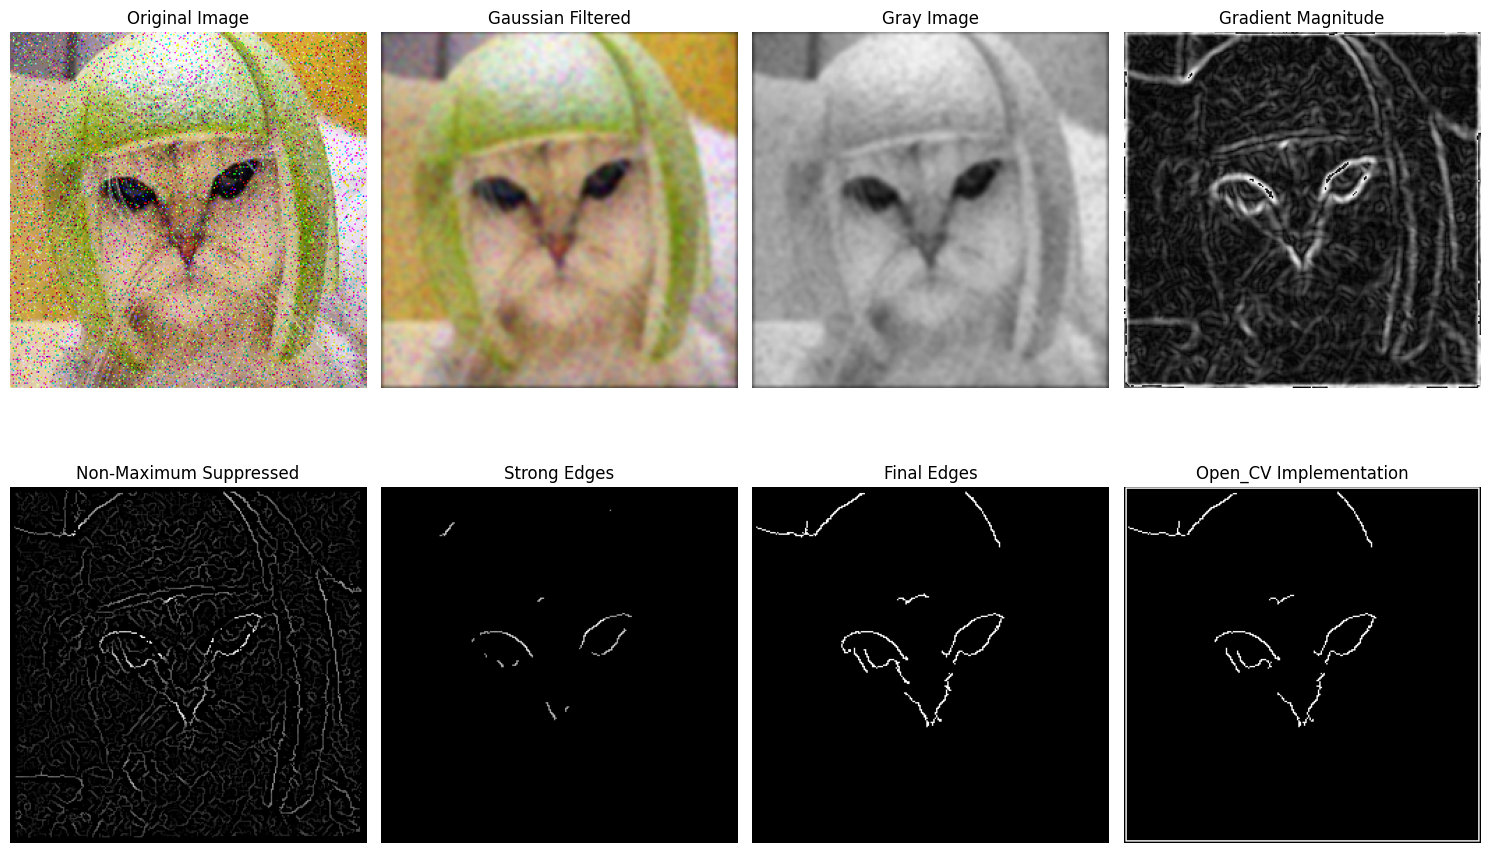

In [17]:
threshold1 = 80 ; threshold2 = 180
image = cv2.imread('cat.jpg')
image = add_impulse_noise(image, noise_prob=0.05)
a = apply_canny_edge_detector_self(image, threshold1, threshold2,plot = True)


We can compare the performace with the OpenCV implementation of the Canny edge detection algorithm. 

In [22]:
image = cv2.imread('cat.jpg')
image = add_impulse_noise(image, noise_prob=0.05)

rmse = compare_canny_edge_detectors(image, threshold1, threshold2)
print(f"RMSE between custom and OpenCV Canny Edge Detectors: {rmse:.4f}")

RMSE between custom and OpenCV Canny Edge Detectors: 0.1862


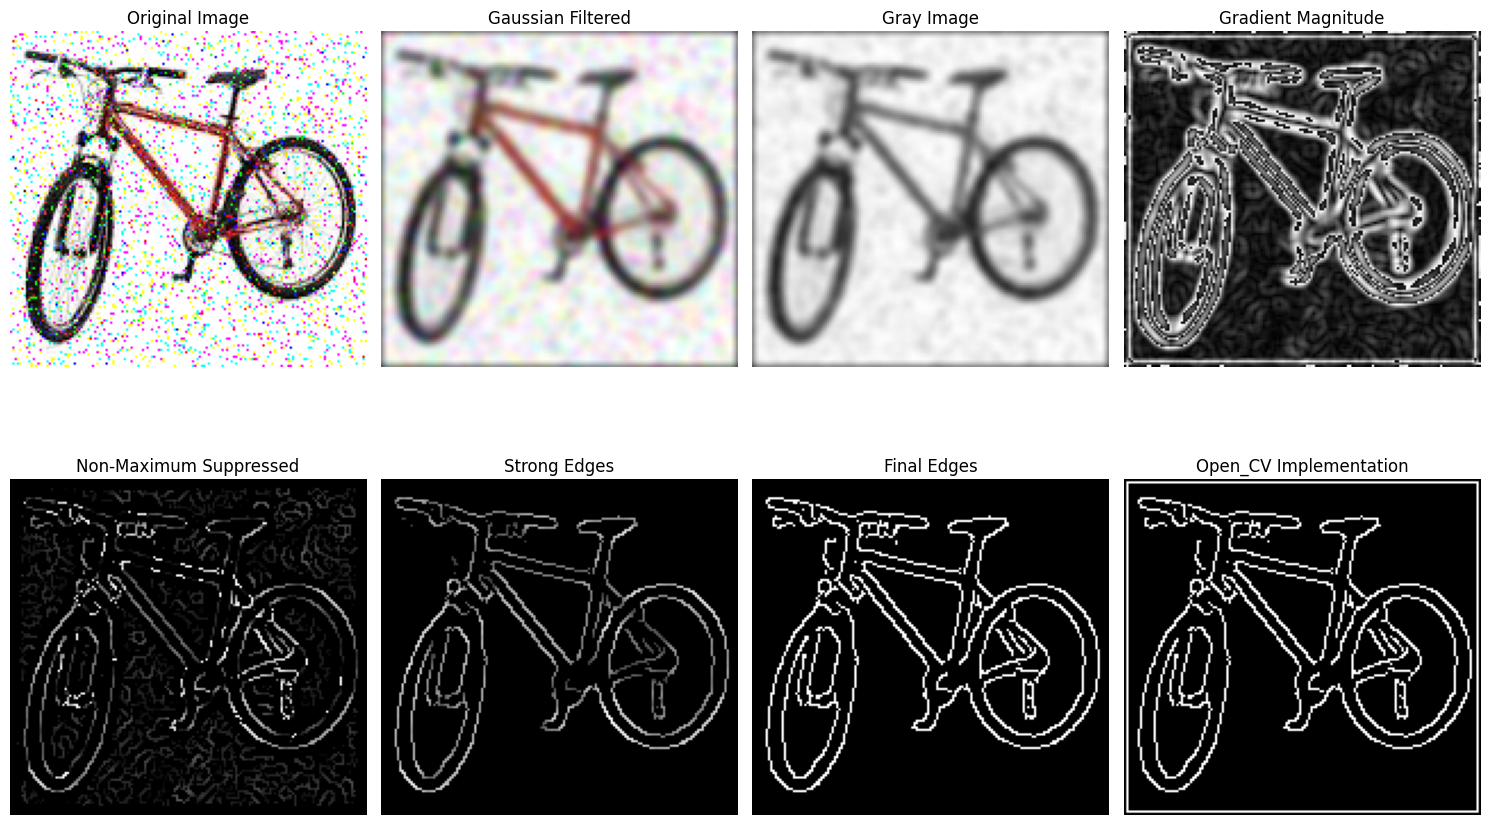

In [23]:
threshold1 = 30 ; threshold2 = 120
image = cv2.imread('cycle.jpeg')
image = add_impulse_noise(image, noise_prob=0.05)
a = apply_canny_edge_detector_self(image, threshold1, threshold2)

In [24]:
image = cv2.imread('cycle.jpeg')
image = add_impulse_noise(image, noise_prob=0.05)

rmse = compare_canny_edge_detectors(image, threshold1, threshold2)
print(f"RMSE between custom and OpenCV Canny Edge Detectors: {rmse:.4f}")

RMSE between custom and OpenCV Canny Edge Detectors: 0.1707


Reference : 
1. http://vision.stanford.edu/teaching/cs131_fall1718/files/06_notes.pdf
2. https://en.wikipedia.org/wiki/Canny_edge_detector
3. https://books.google.co.in/books?hl=en&lr=&id=a62xQ2r_f8wC&oi=fnd&pg=PA19&dq=digital+image+processing&ots=3B1yO1nE1D&sig=UPA_8QAuKPbJpSHDKw84BniVGFs&redir_esc=y#v=onepage&q=digital%20image%20processing&f=false
4. https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de